# Проект по дисперсионному анализу

Есть приложении по доставке готовых продуктов.  Коллега принес результаты двух тестов:

- В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
    
- Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый


**Цель проекта:**

- проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.


**Сформулируем гиротезы:**

Тест 1:

- Нулевая гипотеза (H0): Разницы между разрешением фотографий блюд в приложении в тестовой и контрольной группе нет

- Альтернативная гипотеза (H1): Разница между разрешением фотографий блюд в приложении в тестовой и контрольной группе есть

Тест 2:

- Нулевая гипотеза (H0): Разницы между старой и новой кнопкой для заказов в приложении в тестовой и контрольной группе нет

- Альтернативная гипотеза (H1): Разница между старой и новой кнопкой для заказов в приложении в тестовой и контрольной группе есть


**Описание данных:**

5_task_1:

- id – id клиента в эксперименте
- group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- events – сколько блюд суммарно было заказано за период

5_task_2:

- id – id клиента в эксперименте
- segment – сегмент (high/low)
- group – вид кнопки (control – старая версия, test – новая версия)
- events – сколько блюд суммарно было заказано за период

Задания:
1. Выберите метод, который предположительно подойдет в первом вопросе.
2. Проверьте, являются ли дисперсии внутри групп гомогенными.
3. Проведите тест на нормальность распределения.
4. Сравните средние в представленных группах.
5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 
6. Примите решение: какие картинки в итоге будем использовать?
7. Выберите метод для второго теста.
8. Визуализируйте распределение events для контрольной и тестовой групп. 
9. Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 
10.Выберите формулу для модели, проведите тест.



In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import pylab

###  Загрузка и изучение данных

In [2]:
# считываем данные, смотрим их характеристики через метод info()

df1 = pd.read_csv('/Users/oksana_khoroshun/Documents/Python/5_task_1.csv') 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30000 non-null  int64 
 1   group   30000 non-null  object
 2   events  30000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 703.2+ KB


In [3]:
#смотрим первые 5 строк

df1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [4]:
# считываем данные, смотрим их характеристики через метод info()

df2 = pd.read_csv('/Users/oksana_khoroshun/Documents/Python/5_task_2.csv') 
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  int64  
 1   group    100000 non-null  object 
 2   segment  100000 non-null  object 
 3   events   100000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [5]:
#смотрим первые 5 строк

df2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


### 1. Выбор метода для Теста 1

Нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

- A – прямоугольные 16:9
- B – квадратные
- C – прямоугольные 12:4

Воспользуемся методом  value_counts(), что посмотреть данный о количестве пользователей, которые увидели разные форматы фотографий.

In [6]:
df1.group.value_counts()

A    10000
B    10000
C    10000
Name: group, dtype: int64

Для сравнения средних в данном случае лучше использовать статистический тест ANOVA.


### 2. Проверка гомогенности дисперсии внутри групп 

Далее проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [7]:
pg.homoscedasticity(df1, dv='events', group='group', method='levene')

,W,pval,equal_var
levene,2.26226,0.104133,True


p-value > 0.05, не отклоняем нулевую гипотезу о том, что дисперсии гомогенны.

### 3. Тест на нормальность распределения

Для того, чтобы убедиться, что данные распределены нормально, применим тест Шапиро-Уилка. 

Сделаем семплирование перед применением критерия при проверке на нормальность (и для теста, и для контроля), так как на больших выборках мы можем получать неверные результаты. 

Чувствительность любого теста зависит от размера выборки. Это касается и теста Шапиро-Уилка - на больших выборках он детектирует даже самые незначительные отклонения от нормальности. Поэтому мы берём случайные 1000 значений из выборки, чтобы обойти этот недостаток.

Есть шанс, что случайные 1000 значений всё же сформируют ненормальное распределение, поэтому будем использовать аргумент `random_state=17` для стабильности и воспроизводимости результатов.

In [8]:
# создадим переменные, в который будут разделены группы A, B и С


df1_a = df1.query('group == "A"') 

df1_b = df1.query('group == "B"')

df1_c = df1.query('group == "C"') 

In [9]:
# формируем А sample

a_sample = df1_a[df1_a['group'] == 'A']['events'].sample(1000, random_state=17)

In [10]:
# формируем B sample

b_sample = df1_b[df1_b['group'] == 'B']['events'].sample(1000, random_state=17)

In [11]:
# формируем C sample

c_sample = df1_c[df1_c['group'] == 'C']['events'].sample(1000, random_state=17)

In [12]:
# проверяем  a_sample с помощью теста Шапиро-Уилка 

stats.shapiro(a_sample)

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [13]:
# проверяем  b_sample с помощью теста Шапиро-Уилка 

stats.shapiro(b_sample)

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

In [14]:
# проверяем  c_sample с помощью теста Шапиро-Уилка 

stats.shapiro(c_sample)

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

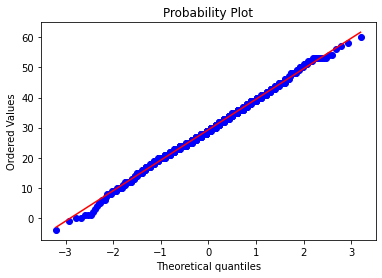

In [15]:
# построим qq-plot по количеству заказов для a_sample

stats.probplot(a_sample, dist="norm", plot=pylab)
pylab.show()

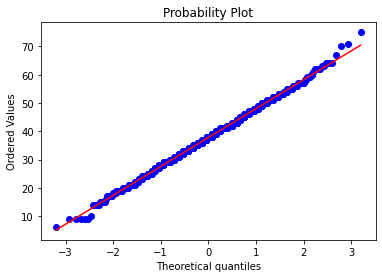

In [16]:
# построим qq-plot по количеству заказов для b_sample

stats.probplot(b_sample, dist="norm", plot=pylab)
pylab.show()

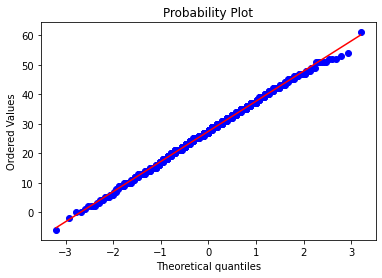

In [17]:
# построим qq-plot по количеству заказов для c_sample

stats.probplot(c_sample, dist="norm", plot=pylab)
pylab.show()

По результатам тестов мы видим, что распределения events в группе A, B и С  являются нормальными.

Сравним результаты теста Шапиро-Уилка с тестом на нормальность normaltest:

In [18]:
pg.normality(data=df1, dv="events", group="group", method="normaltest")

,W,pval,normal
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


Normaltest также показывает, что распределения events в группе A, B и С являются нормальными.

### 4. Сравнение средних в группах.

In [19]:
# сохраним в переменные количество заказов для каждой группы

a = df1.query("group == 'A'").events
b = df1.query("group == 'B'").events
c = df1.query("group == 'C'").events

In [20]:
# проведем однофакторный дисперсионный анализ

ss.f_oneway(a ,b, c)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)


Для сравнения средних я использовала однофакторный дисперсионный анализ. Значение статистики равно 2886, а р-уровень значимости составил 0.


### 5. Критерий Тьюки

Далее будем использовать критерий Тьюки, чтобы определить, между какими группами есть статистически значимые различия. 

In [21]:
# через библиотеку statsmodels

pairwise_tukeyhsd(df1.events, df1.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


In [22]:
# через библиотеку pingouin

pg.pairwise_tukey(data=df1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.018089


Попарные сравнения с помощью критерия Тьюки в исполнении двух библиотек показали значимые статистические различия между всеми группами.

### 6. Выбор формата картинки

После проведенного анализа мы можем сделать вывод, что формат картинки для приложения лучше выбирать квадратный (вариант В), так как в этой группе наблюдается наибольшая разница в средних.

### 7. Выбор метода для Теста 2

Воспользуемся методом  value_counts(), что посмотреть данный о количестве пользователей, которые увидели разные кнопки.

In [23]:
df2.group.value_counts()

test       50000
control    50000
Name: group, dtype: int64

Поскольку у нас есть две разбивки по группам, анализировать несколько групп нам поможет многофакторный дисперсионный анализ.

### 8. Визуализизация распределение events для контрольной и тестовой групп

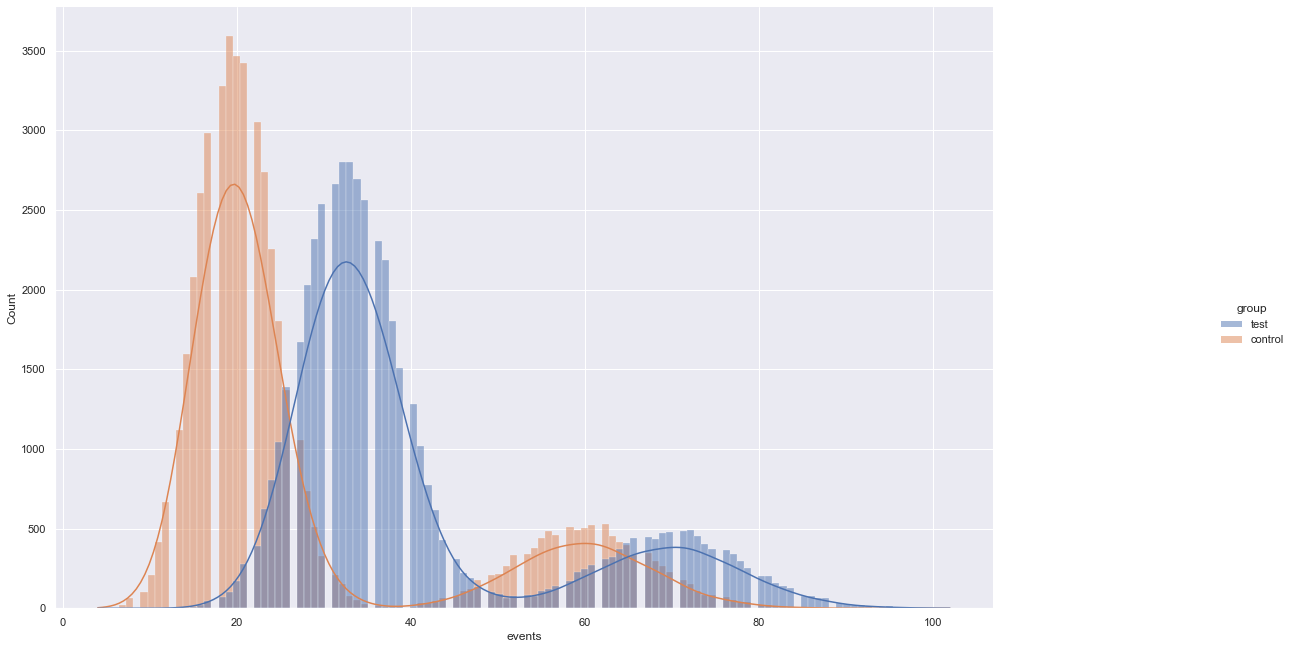

In [24]:
# посмотрим распределение events по группам

sns.set_theme()
g = sns.displot(data=df2, x='events',hue='group', kde=True)

g.figure.set_figwidth(20)
g.figure.set_figheight(10)

### 9. Описательные статистики events в разбивке по группе и по сегменту пользователя

Далее посчитаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 


In [25]:
df2.groupby(['group', 'segment'], as_index=False) \
   .agg({'events': 'describe'})


group segment   events                                               \
                      count       mean       std   min   25%   50%   75%   
0  control    high  10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   
1  control     low  40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   
2     test    high  10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0   
3     test     low  40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   

          
     max  
0   89.0  
1   41.0  
2  102.0  
3   59.0

### 10. Проведение теста

Чтобы понять между какими группами есть статистически значимые различия, проведем тест

In [26]:
# проверим эффект нескольких переменных – group и segment – на events, с взаимодействием факторов

model_main = smf.ols("events ~ C(group) * C(segment)", data=df2).fit()
anova_lm(model_main, typ = 2)

,sum_sq,df,F,PR(>F)
C(group),3.837195e+06,1.0,112031.864119,0.000000e+00
C(segment),2.362480e+07,1.0,689756.377485,0.000000e+00
C(group):C(segment),3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


Из полученных данных мы видим, что следует проверить взаимодействие тестовой и контрольной группы с сегментами.

In [27]:
# для последующих сравнений между группами соединим колонки group и segment в новую колонку combination

df2['combination'] = df2['group'] + ' \ ' + df2['segment']

In [28]:
df2

,id,group,segment,events,combination
0,83440,test,high,78.0,test \ high
1,96723,test,high,71.0,test \ high
2,68719,test,high,80.0,test \ high
3,50399,test,high,80.0,test \ high
4,95613,test,high,78.0,test \ high
...,...,...,...,...,...
99995,60695,control,low,15.0,control \ low
99996,5934,control,low,16.0,control \ low
99997,30046,control,low,22.0,control \ low
99998,26474,control,low,21.0,control \ low


In [29]:
# проведем тест Тьюки

pg.pairwise_tukey(data=df2, dv='events', between='combination')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control \ high,control \ low,59.970800,20.031575,39.939225,0.065432,610.391461,0.0,6.824282
1,control \ high,test \ high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.0,-1.703109
2,control \ high,test \ low,59.970800,33.025925,26.944875,0.065432,411.798717,0.0,4.603981
3,control \ low,test \ high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.0,-8.527429
4,control \ low,test \ low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.0,-2.220314
5,test \ high,test \ low,69.938500,33.025925,36.912575,0.065432,564.135148,0.0,6.307128


Исходя из полученных данных делаем выводы о том, что:

- для обоих сегментов (high и low) показатели статистически значимо увеличились по сравнению с контрольной группой

- разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13
 
- разница между control/high и test/high составила около 10


Далее визуализируем результаты анализа.

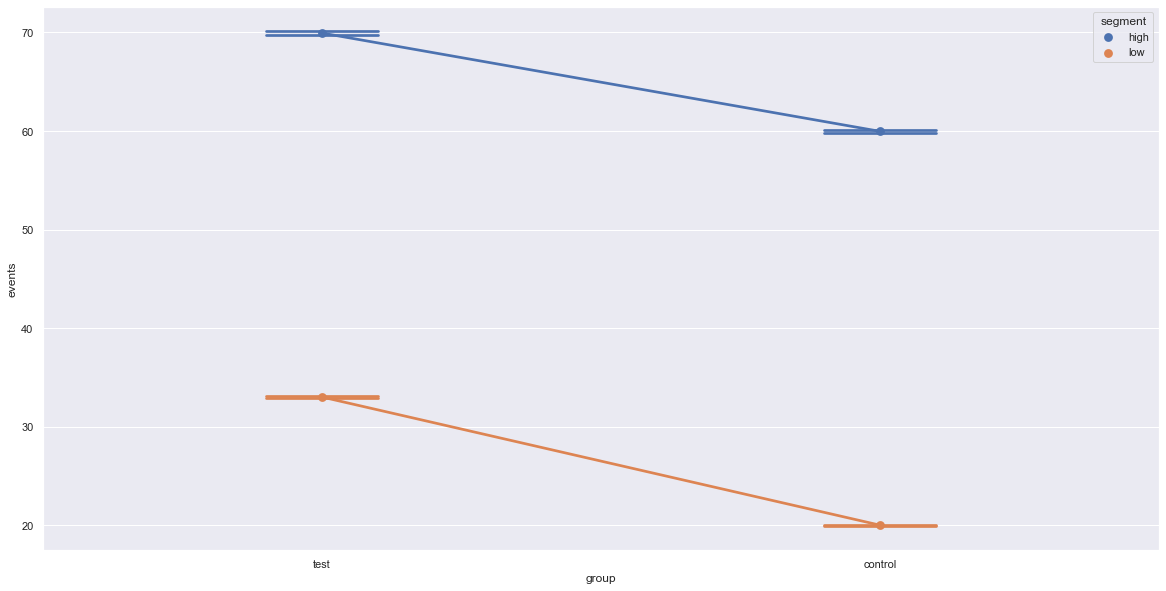

In [30]:
sns.set_theme()
g = sns.pointplot(x="group", y="events", hue="segment", data=df2, capsize=0.2)

g.figure.set_figwidth(20)
g.figure.set_figheight(10)

Исходя из полученных данных фактор group оказался значимым, фактор segment – значимым, их взаимодействие также значимо. Судя по графику, для всех групп среднее значение events увеличилось, поэтому рационально будет принять решение применении новой версии кнопки.


### Заключение

В этом проекте я решала две задачи: 

1. Какой формат фотографий выбрать для приложения?
2. Стоит ли применять новую версию кнопки?

Для решения первой задачи я использовала однофакторный дисперсионный анализ. С помощью критерия Тьюки я пришла к выводу, что следует отклонить нулевую гипотезу и для приложения лучше применять квадратный (вариант В) формат картинки блюд.

Для решения второй задачи я применяла многофакторый дисперсионный анализ. Среди факторов - группа и сегменты, также я смотрела их взаимодействие. Статистически значимые различия оказались между указанными факторами, а также между их взаимодействием. В этом случае я также отклонила нулевую гипотезу. Визуализация результата анализа показала, что для всех групп среднее значение events увеличилось. Поэтому стоит принять решение о применении новой версии кнопки